In [5]:
!pip install langchain langchain-community openai tiktoken python-dotenv
!pip install langgraph langgraph-checkpoint-sqlite langchain_openai gradio tavily-python

In [6]:
import os

In [8]:
os.environ["OPENAI_API_KEY"] = "your-api-key"

In [9]:
os.environ["TAVILY_API_KEY"] = "your-api-key"

In [10]:
from dotenv import load_dotenv, find_dotenv
import openai
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']
llm_model = "gpt-4o-mini"
client = openai.OpenAI(api_key=openai.api_key)

In [38]:
# ============================================
# 📌 Import Required Libraries
# ============================================

import os  # For environment variables and system configurations
import sqlite3  # Used for in-memory database storage to manage AI workflow state
import operator  # Required for defining numerical operations in AgentState
import time  # Can be used for logging or debugging execution time
from typing import TypedDict, Annotated, List  # Type hinting for better code clarity
from dotenv import load_dotenv  # Loads API keys and environment variables from a .env file
# Load environment variables (Ensure .env contains API keys for OpenAI and Tavily)
_ = load_dotenv()

# Importing required components from LangGraph and LangChain
from langgraph.graph import StateGraph, END  # Defines state-based execution workflow
from langgraph.checkpoint.sqlite import SqliteSaver  # Handles intermediate state storage using SQLite
from langchain_core.messages import SystemMessage, HumanMessage  # Message structures for OpenAI API
from langchain_openai import ChatOpenAI  # GPT-based AI model from OpenAI
from langchain_core.pydantic_v1 import BaseModel  # Used for defining structured model outputs
from tavily import TavilyClient

In [39]:
# ============================================
# 📌 Define AI Agent State (Tracks Execution Flow)
# ============================================

class AgentState(TypedDict):
    """
    This dictionary-like class stores the AI's workflow state,
    ensuring all necessary variables persist across different execution nodes.
    """
    task: str  # The startup idea provided by the user
    lnode: str  # Last executed node (workflow step)
    plan: str  # Business strategy generated in 'strategy' step
    draft: str  # Expanded startup plan from refinement step
    critique: str  # Feedback from 'review' step
    content: List[str]  # Market insights fetched from research
    queries: List[str]  # Research queries generated by AI
    revision_number: int  # Number of times refinement has occurred
    max_revisions: int  # Maximum number of allowed refinements
    count: Annotated[int, operator.add]  # Execution count (keeps track of iterations)

class Queries(BaseModel):
    """ Defines structure for research queries returned by GPT """
    queries: List[str]

# ============================================
# 📌 AI Agent Class (Manages Workflow & AI Calls)
# ============================================

class ewriter():
    def __init__(self):
        """
        Initializes the AI agent with:
        - GPT-4o-mini model (OpenAI)
        - Predefined prompts for each stage
        - API integration with Tavily for research
        - LangGraph workflow with structured nodes for execution
        """

        # ✅ Initialize GPT-4o-mini with moderate creativity
        self.model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

        # ✅ Define Prompts for Different Processing Stages
        self.PLAN_PROMPT = (
            "You are a visionary startup strategist tasked with outlining comprehensive business plans "
            "for emerging companies. Identify the unique selling points (USPs) and core competencies "
            "of startups in various sectors such as tech, healthcare, fintech, and e-commerce."
        )

        self.WRITER_PROMPT = (
            "You are a seasoned startup consultant responsible for crafting compelling pitches "
            "that highlight what sets each company apart. Ensure clarity and persuasive storytelling."
        )

        self.RESEARCH_PLAN_PROMPT = (
            "You are a cutting-edge market research expert specializing in identifying trends "
            "and analyzing competitors within specific industries. Offer actionable insights based on "
            "the latest market data regarding regulatory environments and technological innovations."
        )

        self.REFLECTION_PROMPT = (
            "You are a top-tier investor and mentor providing strategic advice on fundraising, "
            "team building, and operational efficiency tailored to each industry's challenges."
        )

        self.RESEARCH_CRITIQUE_PROMPT = (
            "You are an expert research analyst evaluating the feasibility of new business ideas, "
            "assessing potential risks and rewards based on industry-specific factors like regulatory hurdles."
        )

        # ✅ Initialize Tavily API for Market Research (Handles Import Error)
        try:
            from tavily import TavilyClient
            self.tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
        except ImportError:
            class DummyTavilyClient:
                """ Dummy class for Tavily API when it is unavailable. """
                def __init__(self, api_key):
                    self.api_key = api_key
                def search(self, query: str, max_results: int = 2):
                    return {"results": [{"content": f"Dummy result for '{query}'"}]}
            self.tavily = DummyTavilyClient(api_key="dummy")

        # ✅ Create a StateGraph Workflow
        builder = StateGraph(AgentState)

        # ✅ Define Workflow Nodes (Each node is a step in the process)
        builder.add_node("strategy", self.strategy_node)
        builder.add_node("market_research", self.market_research_node)
        builder.add_node("refinement", self.refinement_node)
        builder.add_node("review", self.review_node)
        builder.add_node("followup_research", self.followup_research_node)

        # ✅ Set Entry Point (First step is strategy generation)
        builder.set_entry_point("strategy")

        # ✅ Define Workflow Transitions (How AI moves between stages)
        builder.add_conditional_edges(
            "refinement",
            self.should_continue,  # Decision-making function
            {END: END, "review": "review"}
        )
        builder.add_edge("strategy", "market_research")
        builder.add_edge("market_research", "refinement")
        builder.add_edge("review", "followup_research")
        builder.add_edge("followup_research", "refinement")

        # ✅ Initialize Checkpointing System (Stores workflow state in-memory)
        memory = SqliteSaver(conn=sqlite3.connect(":memory:", check_same_thread=False))
        self.graph = builder.compile(
            checkpointer=memory,
            interrupt_after=['strategy', 'refinement', 'review', 'market_research', 'followup_research']
        )

    # ============================================
    # 📌 AI Workflow Nodes (Each Stage of Processing)
    # ============================================

    def strategy_node(self, state: AgentState):
        """ Generates a high-level business strategy for the startup. """
        messages = [SystemMessage(content=self.PLAN_PROMPT), HumanMessage(content=state['task'])]
        response = self.model.invoke(messages)
        return {"plan": response.content, "lnode": "strategy", "count": 1}

    def market_research_node(self, state: AgentState):
        """ Generates research queries and fetches market insights via Tavily API. """
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state['task'])
        ])
        content = state['content'] or []
        for q in queries.queries:
            resp = self.tavily.search(query=q, max_results=2)
            for r in resp['results']:
                content.append(r['content'])
        return {"content": content, "queries": queries.queries, "lnode": "market_research", "count": 1}

    def refinement_node(self, state: AgentState):
        """ Expands the startup plan using the research insights. """
        content = "\n\n".join(state['content'] or [])
        user_message = HumanMessage(content=f"{state['task']}\n\nHere is the strategic outline:\n\n{state['plan']}")
        messages = [SystemMessage(content=self.WRITER_PROMPT.format(content=content)), user_message]
        response = self.model.invoke(messages)
        return {"draft": response.content, "revision_number": state.get("revision_number", 1) + 1, "lnode": "refinement", "count": 1}

    def review_node(self, state: AgentState):
        """ Provides investor-style feedback on the startup idea. """
        messages = [SystemMessage(content=self.REFLECTION_PROMPT), HumanMessage(content=state['draft'])]
        response = self.model.invoke(messages)
        return {"critique": response.content, "lnode": "review", "count": 1}

    def followup_research_node(self, state: AgentState):
        """ Conducts additional research based on feedback to strengthen the plan. """
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state['critique'])
        ])
        content = state['content'] or []
        for q in queries.queries:
            resp = self.tavily.search(query=q, max_results=2)
            for r in resp['results']:
                content.append(r['content'])
        return {"content": content, "lnode": "followup_research", "count": 1}

    def should_continue(self, state):
        """ Determines whether refinement should continue or stop. """
        return END if state["revision_number"] > state["max_revisions"] else "review"

In [40]:
import gradio as gr

# Define a class for the Writer GUI using Gradio.
class writer_gui():
    # The initializer sets up the necessary variables and creates the interface.
    def __init__(self, graph, share=False):
        self.graph = graph                # The graph object used for state and process management.
        self.share = share                # Flag to determine if the app should be shared publicly.
        self.partial_message = ""         # Accumulates messages from agent responses.
        self.response = {}                # Holds the response from the graph's invocation.
        self.max_iterations = 10          # Maximum number of iterations for the agent process.
        # Initialize lists to keep track of iterations and threads.
        self.iterations = [0]             # List with initial iteration count for thread 0.
        self.threads = [0]                # List with initial thread id (0) for dropdown selections.
        self.thread_id = 0                # Current active thread id.
        # Set up the initial thread configuration.
        self.thread = {"configurable": {"thread_id": "0"}}
        # Create the Gradio interface by calling the method.
        self.demo = self.create_interface()

    # The run_agent function is responsible for executing the agent's logic.
    def run_agent(self, start, topic, stop_after):
        # If 'start' is True, begin a new iteration with updated configuration.
        if start:
            self.iterations.append(0)  # Append a new iteration counter for the new thread.
            # Set up the configuration dictionary with default values and the provided topic.
            config = {
                'task': topic,
                "max_revisions": 2,
                "revision_number": 0,
                'lnode': "",
                'strategy': "no strategy",
                'draft': "no plan",
                'critique': "no review",
                'content': ["no research content"],
                'queries': "no queries",
                'count': 0
            }
            self.thread_id += 1         # Increment the thread id for the new process.
            self.threads.append(self.thread_id)  # Add the new thread id to the threads list.
        else:
            config = None  # For continuation, configuration remains unchanged.
        # Update the current thread with the new thread id.
        self.thread = {"configurable": {"thread_id": str(self.thread_id)}}

        # Loop until the maximum number of iterations is reached.
        while self.iterations[self.thread_id] < self.max_iterations:
            # Invoke the graph process using the current config and thread.
            self.response = self.graph.invoke(config, self.thread)
            self.iterations[self.thread_id] += 1  # Increment the iteration counter.
            # Append the response to the partial_message, including a separator.
            self.partial_message += str(self.response)
            self.partial_message += "\n------------------\n\n"
            # Retrieve the display state for the current iteration.
            lnode, nnode, _, rev, acount = self.get_disp_state()
            # Yield output values to update the GUI elements.
            yield (self.partial_message, lnode, nnode, self.thread_id, rev, acount)
            # Reset config to None for subsequent iterations.
            config = None
            # Check for termination condition: if there's no next node or last node matches stop_after.
            if not nnode or lnode in stop_after:
                return

    # Retrieves and returns a tuple representing the display state.
    def get_disp_state(self):
        # Get the current state from the graph for the active thread.
        current_state = self.graph.get_state(self.thread)
        lnode = current_state.values["lnode"]       # Last processed node.
        acount = current_state.values["count"]        # Current count of iterations or actions.
        rev = current_state.values["revision_number"] # Current revision number.
        nnode = current_state.next                    # Next node to be processed.
        return lnode, nnode, self.thread_id, rev, acount

    # Update the display state for a given key from the current state.
    def get_state(self, key):
        current_values = self.graph.get_state(self.thread)
        # Check if the key exists in the state values.
        if key in current_values.values:
            lnode, nnode, _, rev, astep = self.get_disp_state()
            # Build a label that includes key state information.
            new_label = f"last_node: {lnode}, thread: {self.thread_id}, rev: {rev}, step: {astep}"
            # Use gr.update to update the element with the new label and corresponding value.
            return gr.update(label=new_label, value=current_values.values[key])
        else:
            return ""

    # Retrieves the research content and updates its display.
    def get_content(self):
        current_values = self.graph.get_state(self.thread)
        # Check if "content" exists in the state.
        if "content" in current_values.values:
            content = current_values.values["content"]
            lnode, nnode, _, rev, astep = self.get_disp_state()
            new_label = f"last_node: {lnode}, thread: {self.thread_id}, rev: {rev}, step: {astep}"
            # Join the list of content items into a single string.
            return gr.update(label=new_label, value="\n\n".join(item for item in content) + "\n\n")
        else:
            return ""

    # Create the entire Gradio interface with various tabs and controls.
    def create_interface(self):
        with gr.Blocks(theme=gr.themes.Default(spacing_size='sm', text_size="sm")) as demo:

            # Helper function to update the display state based on current thread history.
            def updt_disp():
                current_state = self.graph.get_state(self.thread)
                hist = []
                # Iterate over the history of states for the current thread.
                for st in self.graph.get_state_history(self.thread):
                    # Skip steps that are not significant (step < 1).
                    if st.metadata['step'] < 1:
                        continue
                    # Extract relevant details from each state.
                    s_thread_ts = st.config['configurable']['thread_ts']
                    s_tid = st.config['configurable']['thread_id']
                    s_count = st.values['count']
                    s_lnode = st.values['lnode']
                    s_rev = st.values['revision_number']
                    s_nnode = st.next
                    # Append a formatted string for this state.
                    hist.append(f"{s_tid}:{s_count}:{s_lnode}:{s_nnode}:{s_rev}:{s_thread_ts}")
                # Check if state metadata or history is empty.
                if not current_state.metadata or not hist:
                    return {}
                # Return a dictionary of updates for various GUI components.
                return {
                    topic_bx: gr.update(value=str(current_state.values["task"])),
                    lnode_bx: gr.update(value=str(current_state.values["lnode"])),
                    count_bx: gr.update(value=str(current_state.values["count"])),
                    revision_bx: gr.update(value=str(current_state.values["revision_number"])),
                    nnode_bx: gr.update(value=str(current_state.next or "")),
                    threadid_bx: gr.update(value=str(self.thread_id)),
                    thread_pd: gr.update(
                        label="choose thread",
                        choices=self.threads,
                        value=self.thread_id,
                        interactive=True
                    ),
                    step_pd: gr.update(
                        label="update state from: thread:count:last_node:next_node:rev:thread_ts",
                        choices=hist,
                        value=hist[0],
                        interactive=True
                    ),
                }

            # Create the "Agent" tab where the primary interactions occur.
            with gr.Tab("Agent"):
                with gr.Row():
                    # Textbox for entering the startup idea.
                    topic_bx = gr.Textbox(label="Startup Idea", value="Revolutionary AI-driven Healthtech Platform")
                    # Button to initiate generation of the plan.
                    gen_btn = gr.Button("Generate Plan", scale=0, min_width=80, variant='primary')
                    # Button to continue refinement of the plan.
                    cont_btn = gr.Button("Continue Refinement", scale=0, min_width=80)
                with gr.Row():
                    # Several textboxes to display various state values.
                    lnode_bx = gr.Textbox(label="Last Node", min_width=100)
                    nnode_bx = gr.Textbox(label="Next Node", min_width=100)
                    threadid_bx = gr.Textbox(label="Thread", scale=0, min_width=80)
                    revision_bx = gr.Textbox(label="Plan Rev", scale=0, min_width=80)
                    count_bx = gr.Textbox(label="Count", scale=0, min_width=80)
                with gr.Accordion("Manage Agent", open=False):
                    # Create a checkbox group based on available graph nodes (excluding the start node).
                    checks = list(self.graph.nodes.keys())
                    checks.remove('__start__')
                    stop_after = gr.CheckboxGroup(
                        checks,
                        label="Interrupt After State",
                        value=checks,
                        scale=0,
                        min_width=400
                    )
                    with gr.Row():
                        # Dropdowns for thread selection and state step selection.
                        thread_pd = gr.Dropdown(
                            choices=self.threads,
                            interactive=True,
                            label="Select Thread",
                            min_width=120,
                            scale=0
                        )
                        step_pd = gr.Dropdown(
                            choices=['N/A'],
                            interactive=True,
                            label="Select Step",
                            min_width=160,
                            scale=1
                        )
                # Textbox to display live agent output.
                live = gr.Textbox(label="Live Agent Output", lines=5, max_lines=5)
                # List of components to be updated by the helper function.
                sdisps = [topic_bx, lnode_bx, nnode_bx, threadid_bx, revision_bx, count_bx, step_pd, thread_pd]

                # Define actions when the thread dropdown is changed.
                thread_pd.change(
                    self.switch_thread, [thread_pd], None
                ).then(
                    fn=updt_disp, inputs=None, outputs=None
                )
                # Define actions when the step dropdown is changed.
                step_pd.change(
                    self.copy_state, [step_pd], None
                ).then(
                    fn=updt_disp, inputs=None, outputs=None
                )
                # Configure the generate button with a series of chained actions.
                gen_btn.click(
                    fn=lambda stat: gr.update(variant=stat),
                    inputs=gr.Textbox(value="secondary", visible=False),
                    outputs=gen_btn
                ).then(
                    fn=self.run_agent,
                    inputs=[gr.State(value=True), topic_bx, stop_after],
                    outputs=[live, lnode_bx, nnode_bx, threadid_bx, revision_bx, count_bx],
                    show_progress=True
                ).then(
                    fn=updt_disp, inputs=None, outputs=None
                ).then(
                    fn=lambda stat: gr.update(variant=stat),
                    inputs=gr.Textbox(value="primary", visible=False),
                    outputs=gen_btn
                ).then(
                    fn=lambda stat: gr.update(variant=stat),
                    inputs=gr.Textbox(value="primary", visible=False),
                    outputs=cont_btn
                )
                # Configure the continue button similarly.
                cont_btn.click(
                    fn=lambda stat: gr.update(variant=stat),
                    inputs=gr.Textbox(value="secondary", visible=False),
                    outputs=cont_btn
                ).then(
                    fn=self.run_agent,
                    inputs=[gr.State(value=False), topic_bx, stop_after],
                    outputs=[live, lnode_bx, nnode_bx, threadid_bx, revision_bx, count_bx]
                ).then(
                    fn=updt_disp, inputs=None, outputs=None
                ).then(
                    fn=lambda stat: gr.update(variant=stat),
                    inputs=gr.Textbox(value="primary", visible=False),
                    outputs=cont_btn
                )

            # Create a tab for displaying and modifying the strategic outline.
            with gr.Tab("Strategic Outline"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")  # Button to refresh the strategic plan.
                    modify_btn = gr.Button("Modify")    # Button to modify the strategic plan.
                # Textbox to display the strategic outline, allowing interactive edits.
                plan = gr.Textbox(label="Strategic Outline", lines=10, interactive=True)
                # Refresh button fetches the latest plan state.
                refresh_btn.click(
                    fn=self.get_state,
                    inputs=gr.Textbox(value="plan", visible=False),
                    outputs=plan
                )
                # Modify button allows users to edit the plan and update the state.
                modify_btn.click(
                    fn=self.modify_state,
                    inputs=[
                        gr.Textbox(value="plan", visible=False),
                        gr.Textbox(value="strategy", visible=False),
                        plan
                    ],
                    outputs=None
                ).then(
                    fn=updt_disp, inputs=None, outputs=None
                )

            # Create a tab for displaying research content.
            with gr.Tab("Research Content"):
                refresh_btn = gr.Button("Refresh")  # Button to refresh research content.
                # Textbox to display research content.
                content_bx = gr.Textbox(label="Research Content", lines=10)
                # Refresh button updates the research content textbox.
                refresh_btn.click(fn=self.get_content, inputs=None, outputs=content_bx)

            # Create a tab for modifying and reviewing the startup plan.
            with gr.Tab("Startup Plan"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")  # Button to refresh the startup plan.
                    modify_btn = gr.Button("Modify")    # Button to modify the startup plan.
                # Textbox for startup plan draft, allows interaction.
                draft_bx = gr.Textbox(label="Startup Plan Draft", lines=10, interactive=True)
                # Refresh button updates the startup plan from the latest state.
                refresh_btn.click(
                    fn=self.get_state,
                    inputs=gr.Textbox(value="draft", visible=False),
                    outputs=draft_bx
                )
                # Modify button updates the startup plan state.
                modify_btn.click(
                    fn=self.modify_state,
                    inputs=[
                        gr.Textbox(value="draft", visible=False),
                        gr.Textbox(value="refinement", visible=False),
                        draft_bx
                    ],
                    outputs=None
                ).then(
                    fn=updt_disp, inputs=None, outputs=None
                )

            # Create a tab for reviewing critiques and feedback.
            with gr.Tab("Review"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")  # Button to refresh review content.
                    modify_btn = gr.Button("Modify")    # Button to modify the review.
                # Textbox for displaying review or critique, allows interaction.
                critique_bx = gr.Textbox(label="Review / Critique", lines=10, interactive=True)
                # Refresh button fetches the latest critique state.
                refresh_btn.click(
                    fn=self.get_state,
                    inputs=gr.Textbox(value="critique", visible=False),
                    outputs=critique_bx
                )
                # Modify button updates the critique state.
                modify_btn.click(
                    fn=self.modify_state,
                    inputs=[
                        gr.Textbox(value="critique", visible=False),
                        gr.Textbox(value="review", visible=False),
                        critique_bx
                    ],
                    outputs=None
                ).then(
                    fn=updt_disp, inputs=None, outputs=None
                )

            with gr.Tab("State Snapshots"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")  # Button to refresh the state snapshots.
                # Textbox for displaying past states.
                snapshots = gr.Textbox(label="State Snapshots", lines=10)
                # Refresh button retrieves past states for review.
                refresh_btn.click(fn=lambda: self.get_snapshots(), inputs=None, outputs=snapshots)

        return demo  # Return the complete Gradio interface.

    # Method to launch the Gradio interface.
    def launch(self, share=None):
        # If a specific port is set in the environment, use it for launching.
        if port := os.getenv("PORT1"):
            self.demo.launch(share=True, server_port=int(port), server_name="0.0.0.0")
        else:
            self.demo.launch(share=self.share)

    # Method to copy a previous state from the history.
    def copy_state(self, hist_str):
        thread_ts = hist_str.split(":")[-1]  # Extract the timestamp of the thread state.
        config = self.find_config(thread_ts)  # Find the corresponding configuration.
        state = self.graph.get_state(config)  # Get the state associated with the configuration.
        # Update the current thread state with the copied values.
        self.graph.update_state(self.thread, state.values, as_node=state.values['lnode'])
        new_state = self.graph.get_state(self.thread)
        # Return the updated state values for display.
        return (
            new_state.values['lnode'],
            new_state.next,
            new_state.config['configurable']['thread_ts'],
            new_state.values['revision_number'],
            new_state.values['count']
        )

    # Helper method to find a configuration based on a thread timestamp.
    def find_config(self, thread_ts):
        for st in self.graph.get_state_history(self.thread):  # Loop through history.
            cfg = st.config
            if cfg['configurable']['thread_ts'] == thread_ts:
                return cfg  # Return the matching configuration.
        return None  # Return None if no match is found.

    # Method to switch between different threads.
    def switch_thread(self, new_thread_id):
        self.thread = {"configurable": {"thread_id": str(new_thread_id)}}  # Update the thread configuration.
        self.thread_id = int(new_thread_id)  # Update the active thread id.
        return

    # Method to modify a specific key in the current state.
    def modify_state(self, key, asnode, new_state):
        current_values = self.graph.get_state(self.thread)  # Get current values from the graph.
        current_values.values[key] = new_state  # Update the specified key.
        self.graph.update_state(self.thread, current_values.values, as_node=asnode)  # Apply the update.
        return

    # Method to retrieve snapshots of previous states.
    def get_snapshots(self):
        s = ""  # Initialize an empty string to store snapshot data.
        for st in self.graph.get_state_history(self.thread):  # Iterate through state history.
            # Truncate long values to improve readability in snapshots.
            for key in ['plan', 'draft', 'critique']:
                if key in st.values:
                    st.values[key] = st.values[key][:80] + "..."
            if 'content' in st.values:
                for i in range(len(st.values['content'])):
                    st.values['content'][i] = st.values['content'][i][:20] + '...'
            s += str(st) + "\n\n"  # Append the formatted state to the snapshot string.
        return gr.update(label=f"Thread {self.thread_id} Snapshots", value=s)  # Return the formatted snapshots.



In [41]:
# Finally, understand what is happening under the hood, launch the Gradio app
if __name__ == "__main__":
    writer_instance = ewriter()
    gui_instance = writer_gui(writer_instance.graph, share=True)
    gui_instance.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://98613d11c0f75597a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [42]:
!pip install langgraph graphviz

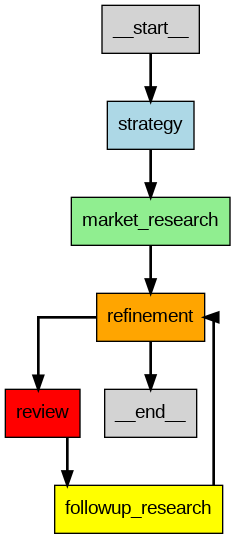

In [43]:
import langgraph
from langgraph.graph import StateGraph
from graphviz import Digraph
from IPython.display import display, Image

# ✅ Ensure ewriter instance is initialized before this step
agent = ewriter()  # Initialize the agent
graph = agent.graph  # Get the LangGraph workflow

# ✅ Create a directed graph using Graphviz with larger size and centered layout
dot = Digraph(format='png', engine='dot')

# ✅ Set global attributes for large visualization and better spacing
dot.attr(size='14,14')  # Increase graph size
dot.attr(rankdir='TB', splines='ortho')  # Arrange nodes from Top-to-Bottom with orthogonal edges

# ✅ Define colors for different stages in the workflow
node_colors = {
    "strategy": "lightblue",
    "market_research": "lightgreen",
    "refinement": "orange",
    "review": "red",
    "followup_research": "yellow",
}

# ✅ Add workflow nodes dynamically with distinct colors
for node in graph.get_graph().nodes:
    color = node_colors.get(node, "lightgray")  # Default to gray if not in predefined mapping
    dot.node(str(node), shape="box", style="filled", fillcolor=color, fontname="Arial", fontsize="14")

# ✅ Add edges (fix: correctly extract source and target nodes)
for edge in graph.get_graph().edges:
    source, target = edge[:2]  # Extract only source and target nodes
    dot.edge(str(source), str(target), color="black", penwidth="2")

# ✅ Render and save the graph image
output_path = '/mnt/data/langgraph_workflow_large'
dot.render(output_path, format='png', cleanup=False)

# ✅ Display the generated image in Colab
display(Image(filename=f"{output_path}.png"))


In [44]:
from IPython.display import display, Markdown

# ✅ Initialize AI agent
writer_instance = ewriter()

# ✅ Create a writer_gui instance if needed (it contains run_agent)
gui_instance = writer_gui(writer_instance.graph, share=False)

# ✅ Define startup idea and stop at "review" node
startup_idea = "AI powered automated social media marketing agency for fashion celebrity"
stop_after_nodes = ["review"]

# ✅ Run the agent and store only the final review output
final_state = None

for output in gui_instance.run_agent(True, startup_idea, stop_after_nodes):
    final_state = output  # Capture the last yielded output

# ✅ Extract only the "critique" text (ignore unnecessary fields)
if final_state:
    review_data = final_state[0]  # Extract review text
    try:
        # Attempt to parse structured data if it's in dictionary format
        if isinstance(review_data, dict) and "critique" in review_data:
            review_text = review_data["critique"]
        else:
            review_text = str(review_data)  # Convert raw text if necessary
    except Exception as e:
        review_text = "❌ Error extracting review: " + str(e)

    # ✅ Format review output with proper bullet points
    formatted_review = "\n\n".join([f"- {line.strip()}" for line in review_text.split("\n") if line.strip()])

    # ✅ Display formatted review output in Google Colab
    display(Markdown(f"### 🔹 FINAL REVIEW OUTPUT\n\n{formatted_review}"))
else:
    display(Markdown("### ❌ No final critique generated."))


/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1360: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


### 🔹 FINAL REVIEW OUTPUT

- {'task': 'AI powered automated social media marketing agency for fashion celebrity', 'lnode': 'strategy', 'plan': "**Business Plan Outline for an AI-Powered Automated Social Media Marketing Agency for Fashion Celebrities**\n\n### Executive Summary\n- **Business Name**: FashionAI Marketing\n- **Mission Statement**: To revolutionize social media marketing for fashion celebrities by leveraging AI technology to create personalized, data-driven marketing strategies that enhance brand visibility and engagement.\n- **Vision**: To be the leading AI-driven marketing agency in the fashion industry, recognized for innovative solutions that empower celebrities to connect authentically with their audience.\n\n### Unique Selling Points (USPs)\n1. **AI-Driven Personalization**: Utilize advanced algorithms to analyze audience behavior and preferences, enabling tailored content that resonates with followers.\n2. **Real-Time Analytics**: Provide clients with real-time insights and performance metrics, allowing for agile adjustments to marketing strategies based on current trends and audience engagement.\n3. **Automated Content Creation**: Leverage AI tools to generate high-quality, visually appealing content (images, videos, captions) that aligns with the celebrity’s brand and audience expectations.\n4. **Influencer Collaboration Platform**: Facilitate partnerships with other fashion influencers and brands through AI matchmaking, enhancing collaborative marketing efforts.\n5. **Enhanced Engagement Strategies**: Implement AI tools to optimize posting schedules, hashtags, and engagement tactics, maximizing reach and interaction rates.\n6. **Scalability**: Offer scalable solutions that cater to both high-profile celebrities and emerging fashion influencers, ensuring accessibility and growth potential.\n\n### Core Competencies\n1. **Expertise in Fashion Marketing**: A deep understanding of fashion trends, consumer behavior, and celebrity branding to create impactful marketing strategies.\n2. **AI Technology Integration**: Proficiency in utilizing AI tools for content generation, audience analysis, and campaign optimization.\n3. **Data Analytics**: Strong capabilities in interpreting data to inform marketing decisions, track performance, and predict future trends.\n4. **Creative Content Development**: A talented team of designers and content creators who can produce visually stunning and engaging marketing materials.\n5. **Social Media Management**: Comprehensive knowledge of various social media platforms and their algorithms to maximize visibility and engagement.\n6. **Relationship Building**: Strong connections within the fashion industry, including influencers, brands, and media outlets, to facilitate collaborations and partnerships.\n\n### Market Analysis\n- **Target Market**: Fashion celebrities, influencers, and emerging designers looking to enhance their social media presence and engagement.\n- **Market Trends**: Growing reliance on AI in marketing, increasing importance of personal branding in the fashion industry, and the rise of influencer marketing.\n- **Competitive Landscape**: Identify key competitors in the social media marketing space, analyze their offerings, and highlight FashionAI Marketing's differentiators.\n\n### Marketing Strategy\n1. **Brand Positioning**: Position FashionAI Marketing as the go-to agency for fashion celebrities seeking innovative and effective social media marketing solutions.\n2. **Content Marketing**: Create engaging blog posts, case studies, and whitepapers showcasing the benefits of AI in social media marketing.\n3. **Social Media Campaigns**: Utilize the agency’s expertise to run targeted campaigns that highlight client successes and attract new business.\n4. **Partnerships**: Collaborate with fashion industry events and influencers to increase brand visibility and credibility.\n\n### Financial Projections\n- **Revenue Streams**: Subscription-based services, one-time campaign fees, and performance-based incentives.\n- **Cost Structure**: Initial investment in AI technology, marketing expenses, salaries for creative and technical staff.\n- **Break-even Analysis**: Estimate timeline for profitability based on client acquisition and retention rates.\n\n### Conclusion\nFashionAI Marketing aims to fill a niche in the fashion industry by providing AI-powered social media marketing solutions tailored specifically for fashion celebrities. By harnessing technology and creativity, the agency will empower clients to enhance their brand presence and engage meaningfully with their audiences, ultimately driving growth and success in an increasingly competitive market.", 'draft': 'no plan', 'critique': 'no review', 'content': ['no research content'], 'queries': 'no queries', 'revision_number': 0, 'max_revisions': 2, 'count': 1}

- ------------------

- {'task': 'AI powered automated social media marketing agency for fashion celebrity', 'lnode': 'market_research', 'plan': "**Business Plan Outline for an AI-Powered Automated Social Media Marketing Agency for Fashion Celebrities**\n\n### Executive Summary\n- **Business Name**: FashionAI Marketing\n- **Mission Statement**: To revolutionize social media marketing for fashion celebrities by leveraging AI technology to create personalized, data-driven marketing strategies that enhance brand visibility and engagement.\n- **Vision**: To be the leading AI-driven marketing agency in the fashion industry, recognized for innovative solutions that empower celebrities to connect authentically with their audience.\n\n### Unique Selling Points (USPs)\n1. **AI-Driven Personalization**: Utilize advanced algorithms to analyze audience behavior and preferences, enabling tailored content that resonates with followers.\n2. **Real-Time Analytics**: Provide clients with real-time insights and performance metrics, allowing for agile adjustments to marketing strategies based on current trends and audience engagement.\n3. **Automated Content Creation**: Leverage AI tools to generate high-quality, visually appealing content (images, videos, captions) that aligns with the celebrity’s brand and audience expectations.\n4. **Influencer Collaboration Platform**: Facilitate partnerships with other fashion influencers and brands through AI matchmaking, enhancing collaborative marketing efforts.\n5. **Enhanced Engagement Strategies**: Implement AI tools to optimize posting schedules, hashtags, and engagement tactics, maximizing reach and interaction rates.\n6. **Scalability**: Offer scalable solutions that cater to both high-profile celebrities and emerging fashion influencers, ensuring accessibility and growth potential.\n\n### Core Competencies\n1. **Expertise in Fashion Marketing**: A deep understanding of fashion trends, consumer behavior, and celebrity branding to create impactful marketing strategies.\n2. **AI Technology Integration**: Proficiency in utilizing AI tools for content generation, audience analysis, and campaign optimization.\n3. **Data Analytics**: Strong capabilities in interpreting data to inform marketing decisions, track performance, and predict future trends.\n4. **Creative Content Development**: A talented team of designers and content creators who can produce visually stunning and engaging marketing materials.\n5. **Social Media Management**: Comprehensive knowledge of various social media platforms and their algorithms to maximize visibility and engagement.\n6. **Relationship Building**: Strong connections within the fashion industry, including influencers, brands, and media outlets, to facilitate collaborations and partnerships.\n\n### Market Analysis\n- **Target Market**: Fashion celebrities, influencers, and emerging designers looking to enhance their social media presence and engagement.\n- **Market Trends**: Growing reliance on AI in marketing, increasing importance of personal branding in the fashion industry, and the rise of influencer marketing.\n- **Competitive Landscape**: Identify key competitors in the social media marketing space, analyze their offerings, and highlight FashionAI Marketing's differentiators.\n\n### Marketing Strategy\n1. **Brand Positioning**: Position FashionAI Marketing as the go-to agency for fashion celebrities seeking innovative and effective social media marketing solutions.\n2. **Content Marketing**: Create engaging blog posts, case studies, and whitepapers showcasing the benefits of AI in social media marketing.\n3. **Social Media Campaigns**: Utilize the agency’s expertise to run targeted campaigns that highlight client successes and attract new business.\n4. **Partnerships**: Collaborate with fashion industry events and influencers to increase brand visibility and credibility.\n\n### Financial Projections\n- **Revenue Streams**: Subscription-based services, one-time campaign fees, and performance-based incentives.\n- **Cost Structure**: Initial investment in AI technology, marketing expenses, salaries for creative and technical staff.\n- **Break-even Analysis**: Estimate timeline for profitability based on client acquisition and retention rates.\n\n### Conclusion\nFashionAI Marketing aims to fill a niche in the fashion industry by providing AI-powered social media marketing solutions tailored specifically for fashion celebrities. By harnessing technology and creativity, the agency will empower clients to enhance their brand presence and engage meaningfully with their audiences, ultimately driving growth and success in an increasingly competitive market.", 'draft': 'no plan', 'critique': 'no review', 'content': ['no research content', 'Delve into the dynamic evolution of fashion marketing propelled by social media. From leveraging augmented reality and 3D fashion to AI-driven design software, brands are embracing digital garments and NFT marketplaces. These elements are enhancing community engagement, fostering brand loyalty and social commerce integration.', 'AI and Fashion Brand Marketing: AI offers opportunities to gain a deeper understanding of your customer base, providing insights into customer behaviour, creating customised shopping experiences, and forecasting fashion trends based on data analysis. AI Use Cases in Fashion Marketing: AI creates predictive trends based on social media activity and automates content creation for consistent, engaging content and customer segmentation to personalise marketing efforts. As AI continues to reshape the digital marketing landscape in the fashion industry, businesses need to adapt and harness the potential of this innovative technology. As quoted by Debamalya Choudhury, “The fusion of fashion and technology is rewriting the rules, delivering exceptional customer engagement...” Here’s to embracing AI’s incredible potential for content creation, AI marketing, and digital marketing and boldly venturing into this brave new digital world.', 'Council Post: The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights To captivate the attention of today’s tech-savvy consumer, more companies are harnessing the transformative power of artificial intelligence (AI), personalization and data-driven strategies to be effective. In the fashion and lifestyle industries, data-driven decisions help ensure your brand stays relevant. If competitor brands are adopting AI technology to improve their marketing efforts and operations, it’s important to consider similar options to stay competitive. In many ways, AI, personalization and data-driven strategies have become the linchpins to meet these expectations.', 'AI and Fashion Brand Marketing: AI offers opportunities to gain a deeper understanding of your customer base, providing insights into customer behaviour, creating customised shopping experiences, and forecasting fashion trends based on data analysis. AI Use Cases in Fashion Marketing: AI creates predictive trends based on social media activity and automates content creation for consistent, engaging content and customer segmentation to personalise marketing efforts. As AI continues to reshape the digital marketing landscape in the fashion industry, businesses need to adapt and harness the potential of this innovative technology. As quoted by Debamalya Choudhury, “The fusion of fashion and technology is rewriting the rules, delivering exceptional customer engagement...” Here’s to embracing AI’s incredible potential for content creation, AI marketing, and digital marketing and boldly venturing into this brave new digital world.', 'The Use of AI In Advertising – Regulatory Challenges and the New ICC Code - Magnusson Start / News / AI Law / The Use of AI In Advertising – Regulatory Challenges and the New ICC Code The Use of AI In Advertising – Regulatory Challenges and the New ICC Code The aforementioned is also stated in the “Code responsibility” section, specifying that the responsibility to respect the rules of the Code also applies to those responsible for preparing algorithms and the use of artificial intelligence for marketing communications purposes. In the context of data driven marketing, digital marketing and direct marketing communications, it is also set forth that the rules in the Code apply regardless of how they are created, modified or delivered, i.e., whether through automated means such as AI and algorithms or by humans.', 'AI is revolutionizing marketing, but without regulation, it is also a legal and ethical minefield. Companies that don’t proactively implement AI transparency and ethical consent practices will soon find themselves locked out of major global markets. For years, AI-driven marketing has operated in a gray area, pushing the limits of consumer privacy. It’s not a one-time agreement; it’s an ongoing dialogue between brands and consumers, and in an AI-driven world, that conversation never stops. As AI reshapes marketing, brands require specialized expertise to set guardrails, manage risk, and ensure they don’t walk into an ethical or legal landmine. AI is moving faster than regulators, and by the time lawmakers catch up, some brands won’t be around to see it.', 'AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies - i-2 Communications AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies In this blog, we’ll explore the innovations AI brings to social media marketing and how these advancements are reshaping targeting and engagement strategies. AI-driven insights enable marketers to make data-backed decisions, optimizing every aspect of their social media strategy. The Future of AI in Social Media Marketing The future of AI in social media marketing promises even more sophisticated tools for targeting, engagement, and analytics. September 26, 2024Leave a Comment on AI and Social Media Marketing: Innovations in Targeting and Engagement StrategiesUncategorized', 'The Power of AI in Social Media Marketing in 2024 | Vista Social The Power of AI in Social Media Marketing in 2024 The power of AI in social media marketing in 2024 is transforming the industry. AI is swiftly becoming the backbone of social media marketing. One of AI’s most exciting applications in social media marketing is content creation. Video content is king on social media, and AI makes creating engaging videos a breeze. AI-powered chatbots are leveling up customer engagement and service in social media marketing. Crafting Social Posts with AI Assistant: Vista Social’s ChatGPT-powered AI Assistant generates unique and engaging social media posts that match your brand’s style and voice. The future of social media marketing is here, and AI is at its forefront.', 'Understanding the Impact of AI on Fashion Industry Trends and Consumer Behavior [Skip to main content](https://www.linkedin.com/pulse/understanding-impact-ai-fashion-industry-trends-consumer-behavior-qwztc#main-content) Understanding the Impact of AI on Fashion Industry Trends and Consumer Behavior Artificial intelligence (AI) is revolutionizing the fashion industry, impacting trends and consumer behavior. AI has revolutionized fashion industry trends by enabling brands to analyze consumer behavior and predict upcoming trends accurately. AI has transformed the fashion industry by providing new insights into trends and consumer behavior. Artificial intelligence (AI) continues to revolutionize the fashion industry, impacting trends and consumer behavior. From personalizing shopping experiences to forecasting fashion trends, AI has transformed the way fashion brands connect with consumers. AI is transforming the fashion industry, influencing trends and how consumers shop.', 'The fashion industry is integrating AI to enhance customer experiences. The role of AI in the fashion industry presents new opportunities for fashion enthusiasts and designers. As we look toward 2025, several AI-driven design trends are set to emerge, promising to revolutionize how the fashion industry creates and interacts with digital spaces. Custom Garments: AI can generate personalized designs based on individual measurements, style trends, and preferences, presenting new levels of customization. Trend Forecasting: By analyzing social media, fashion shows, and retail data, brands can integrate AI to predict upcoming trends and develop designs that align with shopper demands. From photorealistic imagery to hyper-personalized experiences, AI is set to transform how the industry creates and interacts with design.'], 'queries': ['Current trends in AI-powered social media marketing for fashion celebrities', 'Key competitors in the AI social media marketing space for the fashion industry', 'Regulatory environment affecting AI in marketing and advertising', 'Technological innovations in AI for social media marketing', 'Consumer behavior trends in fashion marketing influenced by AI'], 'revision_number': 0, 'max_revisions': 2, 'count': 2}

- ------------------

- {'task': 'AI powered automated social media marketing agency for fashion celebrity', 'lnode': 'refinement', 'plan': "**Business Plan Outline for an AI-Powered Automated Social Media Marketing Agency for Fashion Celebrities**\n\n### Executive Summary\n- **Business Name**: FashionAI Marketing\n- **Mission Statement**: To revolutionize social media marketing for fashion celebrities by leveraging AI technology to create personalized, data-driven marketing strategies that enhance brand visibility and engagement.\n- **Vision**: To be the leading AI-driven marketing agency in the fashion industry, recognized for innovative solutions that empower celebrities to connect authentically with their audience.\n\n### Unique Selling Points (USPs)\n1. **AI-Driven Personalization**: Utilize advanced algorithms to analyze audience behavior and preferences, enabling tailored content that resonates with followers.\n2. **Real-Time Analytics**: Provide clients with real-time insights and performance metrics, allowing for agile adjustments to marketing strategies based on current trends and audience engagement.\n3. **Automated Content Creation**: Leverage AI tools to generate high-quality, visually appealing content (images, videos, captions) that aligns with the celebrity’s brand and audience expectations.\n4. **Influencer Collaboration Platform**: Facilitate partnerships with other fashion influencers and brands through AI matchmaking, enhancing collaborative marketing efforts.\n5. **Enhanced Engagement Strategies**: Implement AI tools to optimize posting schedules, hashtags, and engagement tactics, maximizing reach and interaction rates.\n6. **Scalability**: Offer scalable solutions that cater to both high-profile celebrities and emerging fashion influencers, ensuring accessibility and growth potential.\n\n### Core Competencies\n1. **Expertise in Fashion Marketing**: A deep understanding of fashion trends, consumer behavior, and celebrity branding to create impactful marketing strategies.\n2. **AI Technology Integration**: Proficiency in utilizing AI tools for content generation, audience analysis, and campaign optimization.\n3. **Data Analytics**: Strong capabilities in interpreting data to inform marketing decisions, track performance, and predict future trends.\n4. **Creative Content Development**: A talented team of designers and content creators who can produce visually stunning and engaging marketing materials.\n5. **Social Media Management**: Comprehensive knowledge of various social media platforms and their algorithms to maximize visibility and engagement.\n6. **Relationship Building**: Strong connections within the fashion industry, including influencers, brands, and media outlets, to facilitate collaborations and partnerships.\n\n### Market Analysis\n- **Target Market**: Fashion celebrities, influencers, and emerging designers looking to enhance their social media presence and engagement.\n- **Market Trends**: Growing reliance on AI in marketing, increasing importance of personal branding in the fashion industry, and the rise of influencer marketing.\n- **Competitive Landscape**: Identify key competitors in the social media marketing space, analyze their offerings, and highlight FashionAI Marketing's differentiators.\n\n### Marketing Strategy\n1. **Brand Positioning**: Position FashionAI Marketing as the go-to agency for fashion celebrities seeking innovative and effective social media marketing solutions.\n2. **Content Marketing**: Create engaging blog posts, case studies, and whitepapers showcasing the benefits of AI in social media marketing.\n3. **Social Media Campaigns**: Utilize the agency’s expertise to run targeted campaigns that highlight client successes and attract new business.\n4. **Partnerships**: Collaborate with fashion industry events and influencers to increase brand visibility and credibility.\n\n### Financial Projections\n- **Revenue Streams**: Subscription-based services, one-time campaign fees, and performance-based incentives.\n- **Cost Structure**: Initial investment in AI technology, marketing expenses, salaries for creative and technical staff.\n- **Break-even Analysis**: Estimate timeline for profitability based on client acquisition and retention rates.\n\n### Conclusion\nFashionAI Marketing aims to fill a niche in the fashion industry by providing AI-powered social media marketing solutions tailored specifically for fashion celebrities. By harnessing technology and creativity, the agency will empower clients to enhance their brand presence and engage meaningfully with their audiences, ultimately driving growth and success in an increasingly competitive market.", 'draft': '# Pitch for FashionAI Marketing: Revolutionizing Social Media for Fashion Celebrities\n\n## Executive Summary\nIntroducing **FashionAI Marketing**, where cutting-edge technology meets the glitz and glamour of the fashion world. Our mission is simple yet powerful: to revolutionize social media marketing for fashion celebrities by utilizing AI to create personalized, data-driven strategies that amplify brand visibility and foster genuine audience engagement. Our vision is to emerge as the leading AI-driven marketing agency in the fashion industry, celebrated for our innovative solutions that empower celebrities to connect authentically with their fans.\n\n## What Sets Us Apart: Unique Selling Points (USPs)\n\n1. **AI-Driven Personalization**: Imagine crafting a social media presence that speaks directly to the heart of your audience. Our advanced algorithms analyze audience behavior and preferences, ensuring that every piece of content resonates deeply, enhancing emotional connections.\n\n2. **Real-Time Analytics**: In the fast-paced world of fashion, staying ahead of trends is crucial. We provide our clients with real-time insights and performance metrics, enabling agile adjustments to marketing strategies that respond to the ever-changing landscape of social media.\n\n3. **Automated Content Creation**: Gone are the days of laborious content planning. Our AI tools generate high-quality, visually stunning content—be it images, videos, or captions—perfectly aligned with the celebrity’s brand identity and audience expectations.\n\n4. **Influencer Collaboration Platform**: We facilitate powerful partnerships through AI matchmaking, connecting fashion celebrities with other influencers and brands to amplify collaborative marketing efforts, enhancing reach and credibility.\n\n5. **Enhanced Engagement Strategies**: Our AI tools optimize posting schedules, hashtags, and engagement tactics, ensuring maximum visibility and interaction rates, which are vital for building a loyal following.\n\n6. **Scalability**: Whether you’re a high-profile celebrity or an emerging designer, our scalable solutions cater to all, ensuring that every client has access to top-tier marketing strategies that foster growth.\n\n## Core Competencies\n\n1. **Expertise in Fashion Marketing**: Our team possesses a profound understanding of fashion trends, consumer behavior, and celebrity branding, allowing us to craft impactful marketing strategies that resonate.\n\n2. **AI Technology Integration**: We are pioneers in integrating AI tools for content generation, audience analysis, and campaign optimization, setting us apart in a competitive landscape.\n\n3. **Data Analytics**: Our strong analytical capabilities allow us to interpret data effectively, informing marketing decisions and predicting future trends with precision.\n\n4. **Creative Content Development**: With a talented team of designers and content creators, we produce visually stunning and engaging marketing materials that capture attention and drive engagement.\n\n5. **Social Media Management**: Our comprehensive knowledge of various social media platforms and their algorithms maximizes visibility and interaction, ensuring our clients shine where it matters most.\n\n6. **Relationship Building**: Our extensive connections within the fashion industry—including influencers, brands, and media outlets—facilitate collaborations and partnerships that enhance our clients’ reach.\n\n## Market Analysis\n\n### Target Market\nOur primary focus is on fashion celebrities, influencers, and emerging designers who are eager to elevate their social media presence and engagement.\n\n### Market Trends\n- The increasing reliance on AI in marketing strategies.\n- The growing importance of personal branding within the fashion industry.\n- The meteoric rise of influencer marketing as a key driver of brand success.\n\n### Competitive Landscape\nWhile there are various players in the social media marketing space, FashionAI Marketing stands out through our unique blend of AI technology, fashion expertise, and personalized service.\n\n## Marketing Strategy\n\n1. **Brand Positioning**: We will position FashionAI Marketing as the premier agency for fashion celebrities seeking innovative and effective social media marketing solutions.\n\n2. **Content Marketing**: Our strategy includes creating engaging blog posts, case studies, and whitepapers that showcase the transformative benefits of AI in social media marketing.\n\n3. **Social Media Campaigns**: Utilizing our expertise, we will run targeted campaigns highlighting client successes, which will serve both as inspiration and a magnet for new business.\n\n4. **Partnerships**: Collaborating with fashion industry events and influencers will enhance our visibility and credibility, positioning us as a thought leader in fashion marketing.\n\n## Financial Projections\n\n### Revenue Streams\nOur revenue will come from subscription-based services, one-time campaign fees, and performance-based incentives, creating a diverse income model.\n\n### Cost Structure\nInitial investments will focus on AI technology, marketing expenses, and salaries for our creative and technical teams, ensuring we attract and retain top talent.\n\n### Break-even Analysis\nWe project a clear timeline for profitability based on anticipated client acquisition and retention rates, with a focus on sustainable growth.\n\n## Conclusion\nFashionAI Marketing is poised to fill a critical niche in the fashion industry by providing AI-powered social media marketing solutions tailored specifically for fashion celebrities. By combining technology with creativity, we empower our clients to enhance their brand presence and engage meaningfully with their audiences. Join us on this journey to redefine social media marketing in the fashion world—where every post is a step towards greater visibility and success.', 'critique': 'no review', 'content': ['no research content', 'Delve into the dynamic evolution of fashion marketing propelled by social media. From leveraging augmented reality and 3D fashion to AI-driven design software, brands are embracing digital garments and NFT marketplaces. These elements are enhancing community engagement, fostering brand loyalty and social commerce integration.', 'AI and Fashion Brand Marketing: AI offers opportunities to gain a deeper understanding of your customer base, providing insights into customer behaviour, creating customised shopping experiences, and forecasting fashion trends based on data analysis. AI Use Cases in Fashion Marketing: AI creates predictive trends based on social media activity and automates content creation for consistent, engaging content and customer segmentation to personalise marketing efforts. As AI continues to reshape the digital marketing landscape in the fashion industry, businesses need to adapt and harness the potential of this innovative technology. As quoted by Debamalya Choudhury, “The fusion of fashion and technology is rewriting the rules, delivering exceptional customer engagement...” Here’s to embracing AI’s incredible potential for content creation, AI marketing, and digital marketing and boldly venturing into this brave new digital world.', 'Council Post: The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights To captivate the attention of today’s tech-savvy consumer, more companies are harnessing the transformative power of artificial intelligence (AI), personalization and data-driven strategies to be effective. In the fashion and lifestyle industries, data-driven decisions help ensure your brand stays relevant. If competitor brands are adopting AI technology to improve their marketing efforts and operations, it’s important to consider similar options to stay competitive. In many ways, AI, personalization and data-driven strategies have become the linchpins to meet these expectations.', 'AI and Fashion Brand Marketing: AI offers opportunities to gain a deeper understanding of your customer base, providing insights into customer behaviour, creating customised shopping experiences, and forecasting fashion trends based on data analysis. AI Use Cases in Fashion Marketing: AI creates predictive trends based on social media activity and automates content creation for consistent, engaging content and customer segmentation to personalise marketing efforts. As AI continues to reshape the digital marketing landscape in the fashion industry, businesses need to adapt and harness the potential of this innovative technology. As quoted by Debamalya Choudhury, “The fusion of fashion and technology is rewriting the rules, delivering exceptional customer engagement...” Here’s to embracing AI’s incredible potential for content creation, AI marketing, and digital marketing and boldly venturing into this brave new digital world.', 'The Use of AI In Advertising – Regulatory Challenges and the New ICC Code - Magnusson Start / News / AI Law / The Use of AI In Advertising – Regulatory Challenges and the New ICC Code The Use of AI In Advertising – Regulatory Challenges and the New ICC Code The aforementioned is also stated in the “Code responsibility” section, specifying that the responsibility to respect the rules of the Code also applies to those responsible for preparing algorithms and the use of artificial intelligence for marketing communications purposes. In the context of data driven marketing, digital marketing and direct marketing communications, it is also set forth that the rules in the Code apply regardless of how they are created, modified or delivered, i.e., whether through automated means such as AI and algorithms or by humans.', 'AI is revolutionizing marketing, but without regulation, it is also a legal and ethical minefield. Companies that don’t proactively implement AI transparency and ethical consent practices will soon find themselves locked out of major global markets. For years, AI-driven marketing has operated in a gray area, pushing the limits of consumer privacy. It’s not a one-time agreement; it’s an ongoing dialogue between brands and consumers, and in an AI-driven world, that conversation never stops. As AI reshapes marketing, brands require specialized expertise to set guardrails, manage risk, and ensure they don’t walk into an ethical or legal landmine. AI is moving faster than regulators, and by the time lawmakers catch up, some brands won’t be around to see it.', 'AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies - i-2 Communications AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies In this blog, we’ll explore the innovations AI brings to social media marketing and how these advancements are reshaping targeting and engagement strategies. AI-driven insights enable marketers to make data-backed decisions, optimizing every aspect of their social media strategy. The Future of AI in Social Media Marketing The future of AI in social media marketing promises even more sophisticated tools for targeting, engagement, and analytics. September 26, 2024Leave a Comment on AI and Social Media Marketing: Innovations in Targeting and Engagement StrategiesUncategorized', 'The Power of AI in Social Media Marketing in 2024 | Vista Social The Power of AI in Social Media Marketing in 2024 The power of AI in social media marketing in 2024 is transforming the industry. AI is swiftly becoming the backbone of social media marketing. One of AI’s most exciting applications in social media marketing is content creation. Video content is king on social media, and AI makes creating engaging videos a breeze. AI-powered chatbots are leveling up customer engagement and service in social media marketing. Crafting Social Posts with AI Assistant: Vista Social’s ChatGPT-powered AI Assistant generates unique and engaging social media posts that match your brand’s style and voice. The future of social media marketing is here, and AI is at its forefront.', 'Understanding the Impact of AI on Fashion Industry Trends and Consumer Behavior [Skip to main content](https://www.linkedin.com/pulse/understanding-impact-ai-fashion-industry-trends-consumer-behavior-qwztc#main-content) Understanding the Impact of AI on Fashion Industry Trends and Consumer Behavior Artificial intelligence (AI) is revolutionizing the fashion industry, impacting trends and consumer behavior. AI has revolutionized fashion industry trends by enabling brands to analyze consumer behavior and predict upcoming trends accurately. AI has transformed the fashion industry by providing new insights into trends and consumer behavior. Artificial intelligence (AI) continues to revolutionize the fashion industry, impacting trends and consumer behavior. From personalizing shopping experiences to forecasting fashion trends, AI has transformed the way fashion brands connect with consumers. AI is transforming the fashion industry, influencing trends and how consumers shop.', 'The fashion industry is integrating AI to enhance customer experiences. The role of AI in the fashion industry presents new opportunities for fashion enthusiasts and designers. As we look toward 2025, several AI-driven design trends are set to emerge, promising to revolutionize how the fashion industry creates and interacts with digital spaces. Custom Garments: AI can generate personalized designs based on individual measurements, style trends, and preferences, presenting new levels of customization. Trend Forecasting: By analyzing social media, fashion shows, and retail data, brands can integrate AI to predict upcoming trends and develop designs that align with shopper demands. From photorealistic imagery to hyper-personalized experiences, AI is set to transform how the industry creates and interacts with design.'], 'queries': ['Current trends in AI-powered social media marketing for fashion celebrities', 'Key competitors in the AI social media marketing space for the fashion industry', 'Regulatory environment affecting AI in marketing and advertising', 'Technological innovations in AI for social media marketing', 'Consumer behavior trends in fashion marketing influenced by AI'], 'revision_number': 1, 'max_revisions': 2, 'count': 3}

- ------------------

- {'task': 'AI powered automated social media marketing agency for fashion celebrity', 'lnode': 'review', 'plan': "**Business Plan Outline for an AI-Powered Automated Social Media Marketing Agency for Fashion Celebrities**\n\n### Executive Summary\n- **Business Name**: FashionAI Marketing\n- **Mission Statement**: To revolutionize social media marketing for fashion celebrities by leveraging AI technology to create personalized, data-driven marketing strategies that enhance brand visibility and engagement.\n- **Vision**: To be the leading AI-driven marketing agency in the fashion industry, recognized for innovative solutions that empower celebrities to connect authentically with their audience.\n\n### Unique Selling Points (USPs)\n1. **AI-Driven Personalization**: Utilize advanced algorithms to analyze audience behavior and preferences, enabling tailored content that resonates with followers.\n2. **Real-Time Analytics**: Provide clients with real-time insights and performance metrics, allowing for agile adjustments to marketing strategies based on current trends and audience engagement.\n3. **Automated Content Creation**: Leverage AI tools to generate high-quality, visually appealing content (images, videos, captions) that aligns with the celebrity’s brand and audience expectations.\n4. **Influencer Collaboration Platform**: Facilitate partnerships with other fashion influencers and brands through AI matchmaking, enhancing collaborative marketing efforts.\n5. **Enhanced Engagement Strategies**: Implement AI tools to optimize posting schedules, hashtags, and engagement tactics, maximizing reach and interaction rates.\n6. **Scalability**: Offer scalable solutions that cater to both high-profile celebrities and emerging fashion influencers, ensuring accessibility and growth potential.\n\n### Core Competencies\n1. **Expertise in Fashion Marketing**: A deep understanding of fashion trends, consumer behavior, and celebrity branding to create impactful marketing strategies.\n2. **AI Technology Integration**: Proficiency in utilizing AI tools for content generation, audience analysis, and campaign optimization.\n3. **Data Analytics**: Strong capabilities in interpreting data to inform marketing decisions, track performance, and predict future trends.\n4. **Creative Content Development**: A talented team of designers and content creators who can produce visually stunning and engaging marketing materials.\n5. **Social Media Management**: Comprehensive knowledge of various social media platforms and their algorithms to maximize visibility and engagement.\n6. **Relationship Building**: Strong connections within the fashion industry, including influencers, brands, and media outlets, to facilitate collaborations and partnerships.\n\n### Market Analysis\n- **Target Market**: Fashion celebrities, influencers, and emerging designers looking to enhance their social media presence and engagement.\n- **Market Trends**: Growing reliance on AI in marketing, increasing importance of personal branding in the fashion industry, and the rise of influencer marketing.\n- **Competitive Landscape**: Identify key competitors in the social media marketing space, analyze their offerings, and highlight FashionAI Marketing's differentiators.\n\n### Marketing Strategy\n1. **Brand Positioning**: Position FashionAI Marketing as the go-to agency for fashion celebrities seeking innovative and effective social media marketing solutions.\n2. **Content Marketing**: Create engaging blog posts, case studies, and whitepapers showcasing the benefits of AI in social media marketing.\n3. **Social Media Campaigns**: Utilize the agency’s expertise to run targeted campaigns that highlight client successes and attract new business.\n4. **Partnerships**: Collaborate with fashion industry events and influencers to increase brand visibility and credibility.\n\n### Financial Projections\n- **Revenue Streams**: Subscription-based services, one-time campaign fees, and performance-based incentives.\n- **Cost Structure**: Initial investment in AI technology, marketing expenses, salaries for creative and technical staff.\n- **Break-even Analysis**: Estimate timeline for profitability based on client acquisition and retention rates.\n\n### Conclusion\nFashionAI Marketing aims to fill a niche in the fashion industry by providing AI-powered social media marketing solutions tailored specifically for fashion celebrities. By harnessing technology and creativity, the agency will empower clients to enhance their brand presence and engage meaningfully with their audiences, ultimately driving growth and success in an increasingly competitive market.", 'draft': '# Pitch for FashionAI Marketing: Revolutionizing Social Media for Fashion Celebrities\n\n## Executive Summary\nIntroducing **FashionAI Marketing**, where cutting-edge technology meets the glitz and glamour of the fashion world. Our mission is simple yet powerful: to revolutionize social media marketing for fashion celebrities by utilizing AI to create personalized, data-driven strategies that amplify brand visibility and foster genuine audience engagement. Our vision is to emerge as the leading AI-driven marketing agency in the fashion industry, celebrated for our innovative solutions that empower celebrities to connect authentically with their fans.\n\n## What Sets Us Apart: Unique Selling Points (USPs)\n\n1. **AI-Driven Personalization**: Imagine crafting a social media presence that speaks directly to the heart of your audience. Our advanced algorithms analyze audience behavior and preferences, ensuring that every piece of content resonates deeply, enhancing emotional connections.\n\n2. **Real-Time Analytics**: In the fast-paced world of fashion, staying ahead of trends is crucial. We provide our clients with real-time insights and performance metrics, enabling agile adjustments to marketing strategies that respond to the ever-changing landscape of social media.\n\n3. **Automated Content Creation**: Gone are the days of laborious content planning. Our AI tools generate high-quality, visually stunning content—be it images, videos, or captions—perfectly aligned with the celebrity’s brand identity and audience expectations.\n\n4. **Influencer Collaboration Platform**: We facilitate powerful partnerships through AI matchmaking, connecting fashion celebrities with other influencers and brands to amplify collaborative marketing efforts, enhancing reach and credibility.\n\n5. **Enhanced Engagement Strategies**: Our AI tools optimize posting schedules, hashtags, and engagement tactics, ensuring maximum visibility and interaction rates, which are vital for building a loyal following.\n\n6. **Scalability**: Whether you’re a high-profile celebrity or an emerging designer, our scalable solutions cater to all, ensuring that every client has access to top-tier marketing strategies that foster growth.\n\n## Core Competencies\n\n1. **Expertise in Fashion Marketing**: Our team possesses a profound understanding of fashion trends, consumer behavior, and celebrity branding, allowing us to craft impactful marketing strategies that resonate.\n\n2. **AI Technology Integration**: We are pioneers in integrating AI tools for content generation, audience analysis, and campaign optimization, setting us apart in a competitive landscape.\n\n3. **Data Analytics**: Our strong analytical capabilities allow us to interpret data effectively, informing marketing decisions and predicting future trends with precision.\n\n4. **Creative Content Development**: With a talented team of designers and content creators, we produce visually stunning and engaging marketing materials that capture attention and drive engagement.\n\n5. **Social Media Management**: Our comprehensive knowledge of various social media platforms and their algorithms maximizes visibility and interaction, ensuring our clients shine where it matters most.\n\n6. **Relationship Building**: Our extensive connections within the fashion industry—including influencers, brands, and media outlets—facilitate collaborations and partnerships that enhance our clients’ reach.\n\n## Market Analysis\n\n### Target Market\nOur primary focus is on fashion celebrities, influencers, and emerging designers who are eager to elevate their social media presence and engagement.\n\n### Market Trends\n- The increasing reliance on AI in marketing strategies.\n- The growing importance of personal branding within the fashion industry.\n- The meteoric rise of influencer marketing as a key driver of brand success.\n\n### Competitive Landscape\nWhile there are various players in the social media marketing space, FashionAI Marketing stands out through our unique blend of AI technology, fashion expertise, and personalized service.\n\n## Marketing Strategy\n\n1. **Brand Positioning**: We will position FashionAI Marketing as the premier agency for fashion celebrities seeking innovative and effective social media marketing solutions.\n\n2. **Content Marketing**: Our strategy includes creating engaging blog posts, case studies, and whitepapers that showcase the transformative benefits of AI in social media marketing.\n\n3. **Social Media Campaigns**: Utilizing our expertise, we will run targeted campaigns highlighting client successes, which will serve both as inspiration and a magnet for new business.\n\n4. **Partnerships**: Collaborating with fashion industry events and influencers will enhance our visibility and credibility, positioning us as a thought leader in fashion marketing.\n\n## Financial Projections\n\n### Revenue Streams\nOur revenue will come from subscription-based services, one-time campaign fees, and performance-based incentives, creating a diverse income model.\n\n### Cost Structure\nInitial investments will focus on AI technology, marketing expenses, and salaries for our creative and technical teams, ensuring we attract and retain top talent.\n\n### Break-even Analysis\nWe project a clear timeline for profitability based on anticipated client acquisition and retention rates, with a focus on sustainable growth.\n\n## Conclusion\nFashionAI Marketing is poised to fill a critical niche in the fashion industry by providing AI-powered social media marketing solutions tailored specifically for fashion celebrities. By combining technology with creativity, we empower our clients to enhance their brand presence and engage meaningfully with their audiences. Join us on this journey to redefine social media marketing in the fashion world—where every post is a step towards greater visibility and success.', 'critique': '# Strategic Advice for FashionAI Marketing\n\n## Fundraising Strategy\n\n1. **Identify Potential Investors**: Target venture capital firms and angel investors with a focus on technology, fashion, and marketing. Look for those who have previously invested in AI-driven startups or fashion tech companies.\n\n2. **Create a Compelling Pitch Deck**: Develop a concise and visually appealing pitch deck that highlights your unique selling points, market potential, and financial projections. Include case studies or hypothetical scenarios demonstrating the effectiveness of your AI solutions.\n\n3. **Leverage Industry Connections**: Utilize your team’s connections within the fashion industry to gain introductions to potential investors. Networking at fashion events and tech conferences can also provide valuable opportunities.\n\n4. **Crowdfunding**: Consider launching a crowdfunding campaign to engage early adopters and build a community around your brand. Platforms like Kickstarter or Indiegogo can help raise initial capital while validating your business model.\n\n5. **Grants and Competitions**: Research grants available for tech startups or fashion innovations. Participating in startup competitions can also provide funding and increase visibility.\n\n## Team Building\n\n1. **Hire Diverse Talent**: Assemble a team with expertise in fashion marketing, AI technology, data analytics, and creative content development. Encourage diversity to foster innovative ideas and perspectives.\n\n2. **Continuous Learning**: Invest in ongoing training for your team to keep them updated on the latest trends in AI and fashion marketing. This can include workshops, online courses, or industry conferences.\n\n3. **Foster a Collaborative Culture**: Create an environment that encourages collaboration and open communication among team members. Utilize project management tools to streamline workflows and ensure everyone is aligned on goals.\n\n4. **Mentorship Programs**: Establish mentorship opportunities within your organization to support the growth of junior team members and facilitate knowledge sharing.\n\n5. **Flexible Work Environment**: Offer flexible working arrangements to attract top talent, especially in a post-pandemic world where work-life balance is increasingly prioritized.\n\n## Operational Efficiency\n\n1. **Invest in Technology**: Leverage the latest AI tools and software to streamline operations, from content creation to analytics. This will enhance productivity and allow your team to focus on strategic initiatives.\n\n2. **Automate Repetitive Tasks**: Identify repetitive tasks that can be automated, such as social media scheduling or reporting. This will free up time for your team to concentrate on creative and strategic work.\n\n3. **Establish Clear KPIs**: Define key performance indicators (KPIs) to measure the success of your marketing campaigns. Regularly review these metrics to identify areas for improvement and adjust strategies accordingly.\n\n4. **Client Feedback Loop**: Implement a system for collecting and analyzing client feedback to continuously refine your services. This will ensure that you remain responsive to client needs and market demands.\n\n5. **Scalable Processes**: Design processes that can easily scale as your client base grows. This includes client onboarding, campaign management, and reporting systems that can accommodate an increasing volume of work without sacrificing quality.\n\n## Conclusion\n\nFashionAI Marketing is positioned to disrupt the fashion marketing landscape with its innovative use of AI technology. By focusing on strategic fundraising, building a talented and diverse team, and optimizing operational efficiency, you can ensure sustainable growth and success in a competitive market. Embrace these strategies to further solidify your position as a leader in AI-driven fashion marketing.', 'content': ['no research content', 'Delve into the dynamic evolution of fashion marketing propelled by social media. From leveraging augmented reality and 3D fashion to AI-driven design software, brands are embracing digital garments and NFT marketplaces. These elements are enhancing community engagement, fostering brand loyalty and social commerce integration.', 'AI and Fashion Brand Marketing: AI offers opportunities to gain a deeper understanding of your customer base, providing insights into customer behaviour, creating customised shopping experiences, and forecasting fashion trends based on data analysis. AI Use Cases in Fashion Marketing: AI creates predictive trends based on social media activity and automates content creation for consistent, engaging content and customer segmentation to personalise marketing efforts. As AI continues to reshape the digital marketing landscape in the fashion industry, businesses need to adapt and harness the potential of this innovative technology. As quoted by Debamalya Choudhury, “The fusion of fashion and technology is rewriting the rules, delivering exceptional customer engagement...” Here’s to embracing AI’s incredible potential for content creation, AI marketing, and digital marketing and boldly venturing into this brave new digital world.', 'Council Post: The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights The Future Of Marketing In The Fashion And Lifestyle Industries: AI, Personalization And Data-Driven Insights To captivate the attention of today’s tech-savvy consumer, more companies are harnessing the transformative power of artificial intelligence (AI), personalization and data-driven strategies to be effective. In the fashion and lifestyle industries, data-driven decisions help ensure your brand stays relevant. If competitor brands are adopting AI technology to improve their marketing efforts and operations, it’s important to consider similar options to stay competitive. In many ways, AI, personalization and data-driven strategies have become the linchpins to meet these expectations.', 'AI and Fashion Brand Marketing: AI offers opportunities to gain a deeper understanding of your customer base, providing insights into customer behaviour, creating customised shopping experiences, and forecasting fashion trends based on data analysis. AI Use Cases in Fashion Marketing: AI creates predictive trends based on social media activity and automates content creation for consistent, engaging content and customer segmentation to personalise marketing efforts. As AI continues to reshape the digital marketing landscape in the fashion industry, businesses need to adapt and harness the potential of this innovative technology. As quoted by Debamalya Choudhury, “The fusion of fashion and technology is rewriting the rules, delivering exceptional customer engagement...” Here’s to embracing AI’s incredible potential for content creation, AI marketing, and digital marketing and boldly venturing into this brave new digital world.', 'The Use of AI In Advertising – Regulatory Challenges and the New ICC Code - Magnusson Start / News / AI Law / The Use of AI In Advertising – Regulatory Challenges and the New ICC Code The Use of AI In Advertising – Regulatory Challenges and the New ICC Code The aforementioned is also stated in the “Code responsibility” section, specifying that the responsibility to respect the rules of the Code also applies to those responsible for preparing algorithms and the use of artificial intelligence for marketing communications purposes. In the context of data driven marketing, digital marketing and direct marketing communications, it is also set forth that the rules in the Code apply regardless of how they are created, modified or delivered, i.e., whether through automated means such as AI and algorithms or by humans.', 'AI is revolutionizing marketing, but without regulation, it is also a legal and ethical minefield. Companies that don’t proactively implement AI transparency and ethical consent practices will soon find themselves locked out of major global markets. For years, AI-driven marketing has operated in a gray area, pushing the limits of consumer privacy. It’s not a one-time agreement; it’s an ongoing dialogue between brands and consumers, and in an AI-driven world, that conversation never stops. As AI reshapes marketing, brands require specialized expertise to set guardrails, manage risk, and ensure they don’t walk into an ethical or legal landmine. AI is moving faster than regulators, and by the time lawmakers catch up, some brands won’t be around to see it.', 'AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies - i-2 Communications AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies AI and Social Media Marketing: Innovations in Targeting and Engagement Strategies In this blog, we’ll explore the innovations AI brings to social media marketing and how these advancements are reshaping targeting and engagement strategies. AI-driven insights enable marketers to make data-backed decisions, optimizing every aspect of their social media strategy. The Future of AI in Social Media Marketing The future of AI in social media marketing promises even more sophisticated tools for targeting, engagement, and analytics. September 26, 2024Leave a Comment on AI and Social Media Marketing: Innovations in Targeting and Engagement StrategiesUncategorized', 'The Power of AI in Social Media Marketing in 2024 | Vista Social The Power of AI in Social Media Marketing in 2024 The power of AI in social media marketing in 2024 is transforming the industry. AI is swiftly becoming the backbone of social media marketing. One of AI’s most exciting applications in social media marketing is content creation. Video content is king on social media, and AI makes creating engaging videos a breeze. AI-powered chatbots are leveling up customer engagement and service in social media marketing. Crafting Social Posts with AI Assistant: Vista Social’s ChatGPT-powered AI Assistant generates unique and engaging social media posts that match your brand’s style and voice. The future of social media marketing is here, and AI is at its forefront.', 'Understanding the Impact of AI on Fashion Industry Trends and Consumer Behavior [Skip to main content](https://www.linkedin.com/pulse/understanding-impact-ai-fashion-industry-trends-consumer-behavior-qwztc#main-content) Understanding the Impact of AI on Fashion Industry Trends and Consumer Behavior Artificial intelligence (AI) is revolutionizing the fashion industry, impacting trends and consumer behavior. AI has revolutionized fashion industry trends by enabling brands to analyze consumer behavior and predict upcoming trends accurately. AI has transformed the fashion industry by providing new insights into trends and consumer behavior. Artificial intelligence (AI) continues to revolutionize the fashion industry, impacting trends and consumer behavior. From personalizing shopping experiences to forecasting fashion trends, AI has transformed the way fashion brands connect with consumers. AI is transforming the fashion industry, influencing trends and how consumers shop.', 'The fashion industry is integrating AI to enhance customer experiences. The role of AI in the fashion industry presents new opportunities for fashion enthusiasts and designers. As we look toward 2025, several AI-driven design trends are set to emerge, promising to revolutionize how the fashion industry creates and interacts with digital spaces. Custom Garments: AI can generate personalized designs based on individual measurements, style trends, and preferences, presenting new levels of customization. Trend Forecasting: By analyzing social media, fashion shows, and retail data, brands can integrate AI to predict upcoming trends and develop designs that align with shopper demands. From photorealistic imagery to hyper-personalized experiences, AI is set to transform how the industry creates and interacts with design.'], 'queries': ['Current trends in AI-powered social media marketing for fashion celebrities', 'Key competitors in the AI social media marketing space for the fashion industry', 'Regulatory environment affecting AI in marketing and advertising', 'Technological innovations in AI for social media marketing', 'Consumer behavior trends in fashion marketing influenced by AI'], 'revision_number': 1, 'max_revisions': 2, 'count': 4}

- ------------------